In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Add file names to individual DataFrames
df_k['File'] = df_match.Kinect
df_z['File'] = df_match.Zeno

## Visual Results

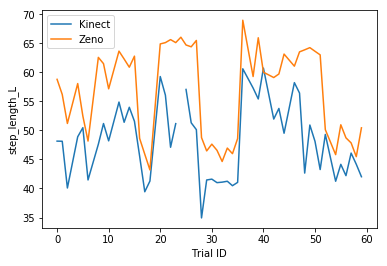

In [3]:
%matplotlib inline

metric = 'step_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

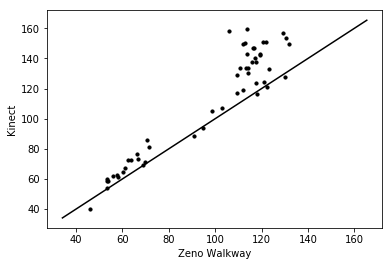

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_velocity_R'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

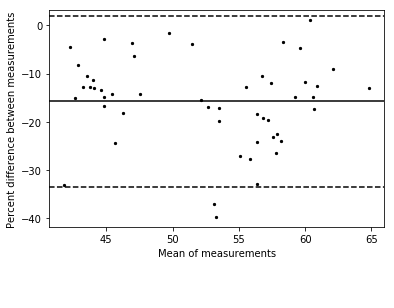

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [6]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.769629,0.908186,0.900112,0.969490,0.925242,0.918469,0.921079,0.948120,0.689981,0.846111
Spearman,0.732398,0.848032,0.829140,0.909991,0.689954,0.672204,0.811674,0.825152,0.587240,0.800905
Abs rel error,0.143507,0.140278,0.135909,0.116288,0.211467,0.219302,0.117260,0.143160,4.626728,4.136707
Bias,-0.157711,-0.152251,-0.147291,-0.123976,-0.241871,-0.251849,0.088885,0.121365,0.944338,0.697072
Range,0.354697,0.232988,0.223838,0.131423,0.440573,0.449679,0.430046,0.391776,9.353698,4.212065


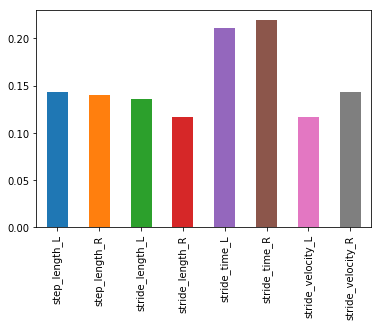

In [7]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [8]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.841209,0.918075
Spearman,0.730081,0.811257
Abs rel error,1.046974,0.951147
Bias,0.097270,0.058072
Range,2.160570,1.083586


In [9]:
df_metric = df_results.groupby(lambda x: x[:-2], axis=1).mean()
df_metric

,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.838907,0.934801,0.921855,0.934599,0.768046
Spearman,0.790215,0.869566,0.681079,0.818413,0.694072
Abs rel error,0.141893,0.126098,0.215384,0.130210,4.381717
Bias,-0.154981,-0.135634,-0.246860,0.105125,0.820705
Range,0.293843,0.177631,0.445126,0.410911,6.782881


In [10]:
df_k.loc[14]

step_length_L                        53.9865
step_length_R                        53.7508
stride_length_L                       107.49
stride_length_R                      110.263
stride_time_L                       0.883333
stride_time_R                       0.891667
stride_velocity_L                    121.614
stride_velocity_R                    123.723
stride_width_L                       12.8813
stride_width_R                       11.8809
File                 2014-12-08_P006_Pre_001
Name: 14, dtype: object

In [11]:
df_z.loc[14]

step_length_L                               60.886
step_length_R                               65.558
stride_length_L                            127.233
stride_length_R                            127.598
stride_time_L                                1.064
stride_time_R                                1.084
stride_velocity_L                          119.657
stride_velocity_R                           117.77
stride_width_L                               8.874
stride_width_R                               8.101
File                 A_2014-12-08_P006_Pre_NC_DT7s
Name: 14, dtype: object